In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import seaborn as sns
import os
import csv

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from scipy.stats import linregress
from scipy.spatial.distance import cdist
from scipy.linalg import polar

import sys
sys.path.insert(0, "..")

from utils import geometry
from utils import fileio

In [2]:
micron_size=553.57
pixel_size=1024

In [4]:
dat_files=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_data/20240117_1_IP_GFPCAAX-CheHis_us_*/*/*/Data/*_cell_data_all*.csv'))
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_data/20240117_1_IP_GFPCAAX-CheHis_us_*/*/*/Matrices'))
save_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'
plot_dir = 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_plots\\20240117_1_IP_GFPCAAX-CheHis_us_8p6/'

In [5]:
tm_spot_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Incremental/Tracked/20240117_1_IP_GFPCAAX-CheHis_us_8p6_SP/5min_int/inc_frames_2/aligned/traces/green_edges/tm_spots.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Incremental/Tracked/20240117_1_IP_GFPCAAX-CheHis_us_8p6_SP/5min_int/inc_frames_2/aligned/traces/green_edges/tm_tracks.csv', skiprows=[1,2,3])
tm_edge_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Incremental/Tracked/20240117_1_IP_GFPCAAX-CheHis_us_8p6_SP/5min_int/inc_frames_2/aligned/traces/green_edges/tm_edges.csv', skiprows=[1,2,3])

cols=['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'shape_parameter', 'circularity', 'cell_edge_count',
       'major_shape_axis_alignment_rads', 'cc_x', 'cc_y', 'track_id', 'spot_id', 'time', 'tm_frame']
dat_df=pd.DataFrame(columns=cols)
for i in range(len(dat_files)):
    tm=tm_spot_dat[tm_spot_dat.FRAME==i][['ID','TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']]

    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])

    dat=pd.read_csv(dat_files[i])

    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)

    # if i<20:
    #     scale_factor=0.72-0.0035*i
    # else:
    #     scale_factor=0.725-0.0018*i

    scale_factor=1.025

    cc=np.vstack((cell_centres[:,0]-np.mean(cell_centres[:,0]),cell_centres[:,1]-np.mean(cell_centres[:,1]))).T
    tm_cc=scale_factor*np.vstack((tm.POSITION_X-np.mean(tm.POSITION_X), -tm.POSITION_Y-np.mean(-tm.POSITION_Y))).T

    # plt.scatter(cc[:,0], cc[:,1])
    # plt.scatter(tm_cc[:,0], tm_cc[:,1])
    # plt.title(str(i))
    # plt.show()

    dists=cdist(cc, tm_cc)
    min_id=np.where(dists==np.min(dists, axis=0))[1]

    dat['cc_x']=cc[:,0]
    dat['cc_y']=cc[:,1]
    dat['track_id']=np.array(tm.TRACK_ID.iloc[min_id])
    dat['spot_id']=np.array(tm.ID.iloc[min_id])
    dat['tm_frame']=np.array(tm.FRAME.iloc[min_id])
    dat['time']=dat['tm_frame']*5
    


    dat_df=pd.concat([dat_df,dat], ignore_index=True)


dat_df["parent_id"] = np.nan
dat_df["divisions"] = 0

t_id=np.max(dat_df.track_id)
Nc_orig=t_id
max_splits=np.max(tm_track_dat.NUMBER_SPLITS)


for s in np.where(tm_track_dat.NUMBER_SPLITS>0)[0]:
    
    splits=np.array(tm_track_dat[tm_track_dat.TRACK_ID==s].NUMBER_SPLITS)[0]

    split=np.where(np.unique(dat_df[dat_df.track_id==s].tm_frame,return_counts=True)[1]>1)[0][0]


    edges=tm_edge_dat[tm_edge_dat.TRACK_ID==s]
    n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
    track_a=[]
    track_b=[]
    track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
    track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])
    
    for i in range(split+1,len(dat_files)):
        n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
        t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
        t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
        track_a=track_a+t_a
        track_b=track_b+t_b
    
    new_id_a=t_id+1
    new_id_b=t_id+2

    dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_a
    dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_b
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=s
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_a
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_b




    t_id=t_id+2

    if splits>1:
        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0])>0):
                split=np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_a]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_a
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0]) >0):
                split=np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_b]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_b
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

dat_df=dat_df.rename(columns={"cell_id": "cell_id_old", "track_id": "cell_id_new"})
dat_df['angle_horizontal']=abs(np.where(dat_df.major_shape_axis_alignment_rads<np.pi/2,dat_df.major_shape_axis_alignment_rads, dat_df.major_shape_axis_alignment_rads-np.pi))
dat_df['cc_x']=dat_df['cc_x']*(micron_size/pixel_size)
dat_df['cc_y']=dat_df['cc_y']*(micron_size/pixel_size)
dat_df.to_csv(save_folder+"/20240117_1_IP_GFPCAAX-CheHis_us_8p6_SP_pooled_mech.csv",index=False)

In [6]:
dat_df=dat_df.sort_values(['time', 'cell_id_new']).reset_index(drop=True)
dat_df['area_norm']=dat_df.cell_area_microns/(dat_df.groupby('cell_id_new').cell_area_microns.transform('first'))
dat_df['perimeter_norm']=dat_df.cell_perimeter_microns/(dat_df.groupby('cell_id_new').cell_perimeter_microns.transform('first'))
dat_df['circularity_norm']=dat_df.circularity/(dat_df.groupby('cell_id_new').circularity.transform('first'))

In [7]:
orig_cells=dat_df[dat_df.cell_id_new<=Nc_orig]

div_list=np.unique(dat_df.parent_id)[~np.isnan(np.unique(dat_df.parent_id))]

#no_div=orig_cells[~orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]
no_div=dat_df[dat_df.cell_id_new.isin(np.where(dat_df.groupby('cell_id_new').count().time==len(dat_files))[0])]



div_cells=dat_df[(dat_df.cell_id_new.isin(div_list))]
daughter_cells=dat_df[dat_df.cell_id_new>Nc_orig]

In [7]:
cell_dat=dat_df.groupby('cell_id_new').min().time.to_frame()
dat_mi=dat_df.set_index(['cell_id_new','time'])
dat_mi['dx0']=dat_mi.cc_x-dat_df.groupby('cell_id_new').first().cc_x
dat_mi['dy0']=dat_mi.cc_y-dat_df.groupby('cell_id_new').first().cc_y
dat_mi['ds0']=np.sqrt(dat_mi.dx0**2 +dat_mi.dy0**2)
dat_mi['ds0_sq']=dat_mi.dx0**2 +dat_mi.dy0**2
cell_dat['MSD']=dat_mi.groupby('cell_id_new').mean().ds0_sq

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_10436\3339878596.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cell_dat['MSD']=dat_mi.groupby('cell_id_new').mean().ds0_sq


C:\Users\v35431nc\AppData\Local\Temp\ipykernel_10436\4028117221.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g=sns.histplot(data=cell_dat,x='MSD', stat='probability',element="step", palette=sns.husl_palette(1,l=.4))


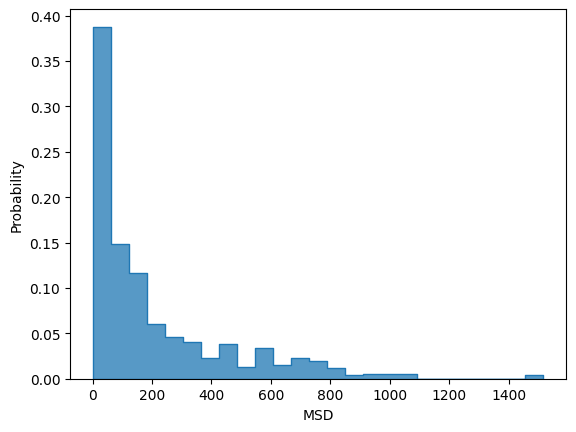

In [8]:
fig, ax=plt.subplots()
g=sns.histplot(data=cell_dat,x='MSD', stat='probability',element="step", palette=sns.husl_palette(1,l=.4))


plt.savefig(plot_dir+'/MSD.png', dpi=300, bbox_inches='tight')

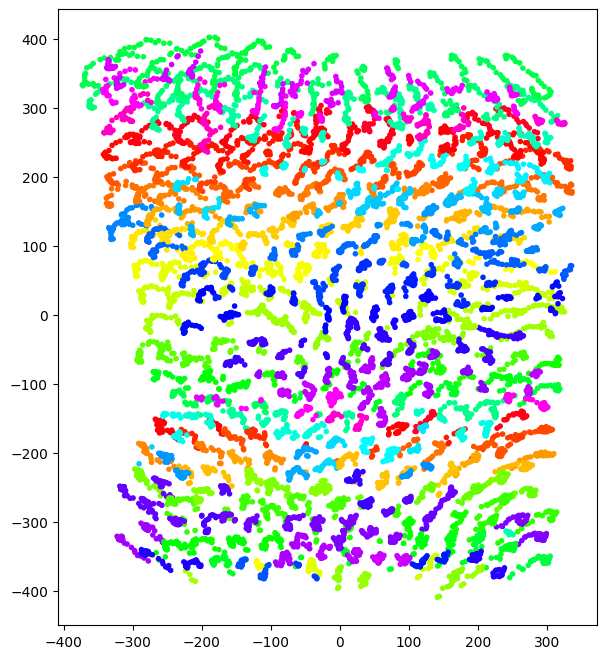

In [373]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in range(len(dat_files)):
    ax.scatter(dat_df[dat_df.tm_frame==i].cc_x, dat_df[dat_df.tm_frame==i].cc_y, marker='.', c=dat_df[dat_df.tm_frame==i].cell_id_new,cmap='gist_rainbow', vmin=0, vmax=np.max(dat_df.cell_id_new))
ax.set_aspect('equal')
plt.show()

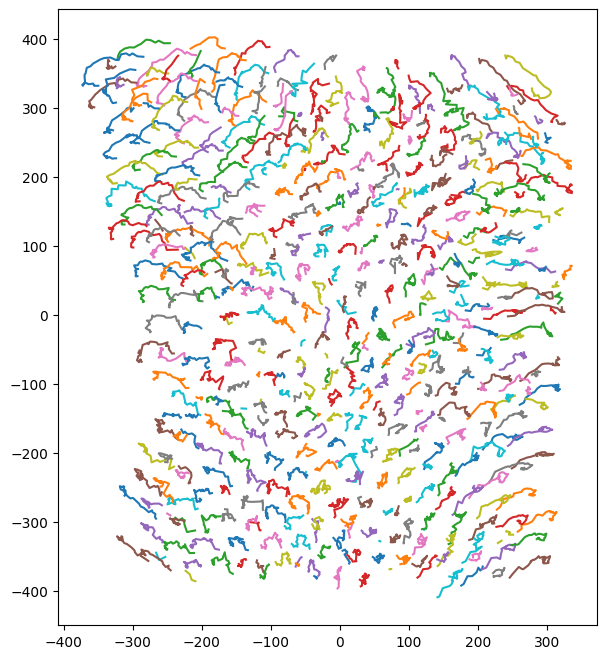

In [374]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in range(np.max(dat_df.cell_id_new)):
    plt.plot(dat_df[dat_df.cell_id_new==i].cc_x, dat_df[dat_df.cell_id_new==i].cc_y)
ax.set_aspect('equal')

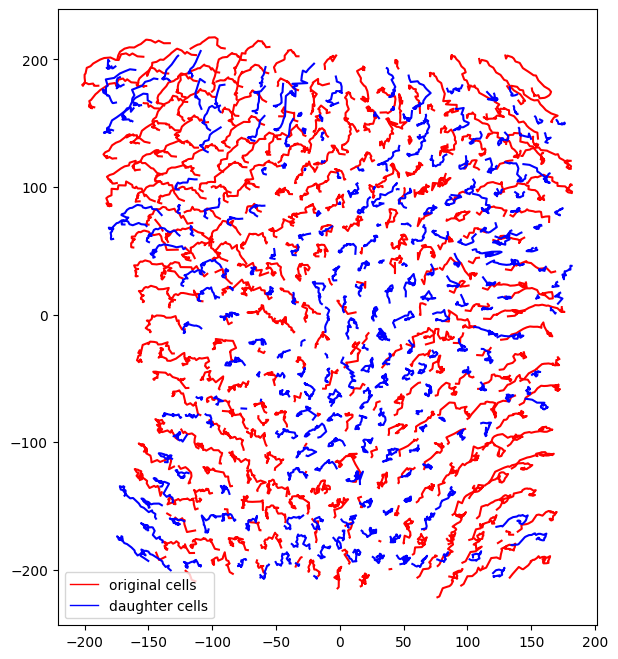

In [11]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in (np.unique(dat_df.cell_id_new)):
    plt.plot(orig_cells[orig_cells.cell_id_new==i].cc_x, orig_cells[orig_cells.cell_id_new==i].cc_y, c='red')
    plt.plot(daughter_cells[daughter_cells.cell_id_new==i].cc_x, daughter_cells[daughter_cells.cell_id_new==i].cc_y, c='blue')

ax.set_aspect('equal')
legend_elements = [Line2D([0], [0], color='r', lw=1, label='original cells'),
                  Line2D([0], [0], color='b', lw=1, label='daughter cells')]
ax.legend(handles=legend_elements)
plt.savefig(plot_dir+'/cell_tracks.png', dpi=300, bbox_inches='tight')


In [376]:
dat_df[(dat_df.cell_id_old==276)&(dat_df.time==0)]

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal,area_norm,perimeter_norm,circularity_norm
138,276.0,154.872788,1569.337447,3.909462,0.304319,10.0,0.623552,-156.784687,-11.547648,138,2416,0,0,NaN,0,0.623552,1.0,1.0,1.0


In [377]:
dat_df[(dat_df.cell_id_old==299)&(dat_df.time==30)]

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal,area_norm,perimeter_norm,circularity_norm
2005,299.0,126.638305,1103.616538,3.812027,0.527192,8.0,2.201151,-152.488759,12.460963,401,3292,30,6,138.0,1,0.940442,1.0,1.0,1.0


In [269]:
dat_df[(dat_df.cell_id_old==258)&(dat_df.time==30)]

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal
1994,258.0,87.034853,494.563102,3.913653,0.441658,7.0,0.73896,-200.828044,-19.842608,400,3354,30,6,138.0,1,0.73896


In [270]:
dat_df[(dat_df.cell_id_old==263)&(dat_df.time==35)]

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal
2307,263.0,99.582606,658.978249,3.879252,0.539583,7.0,2.54024,-150.098676,-0.258414,403,4075,35,7,401.0,2,0.601352


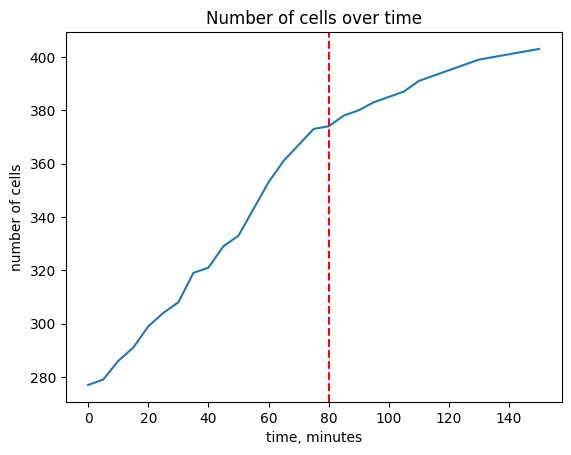

In [12]:
plt.plot(dat_df.groupby('time').count().cell_id_new)
plt.axvline(80, c='r', linestyle='--')
plt.xlabel('time, minutes')
plt.ylabel('number of cells')
plt.title("Number of cells over time")

plt.savefig(plot_dir+'/Number_cells_time.png', dpi=300, bbox_inches='tight')

In [13]:
nd_t0=no_div[no_div.tm_frame==0][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
nd_t80=no_div[no_div.tm_frame==16][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
nd_t150=no_div[no_div.tm_frame==np.max(dat_df.tm_frame)][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
cc_us=pd.merge(nd_t0, nd_t80, on='cell_id_new', suffixes=("_u", "_s"))
cc_us['cc_dx']=cc_us.cc_x_s-cc_us.cc_x_u
cc_us['cc_dy']=cc_us.cc_y_s-cc_us.cc_y_u

cc_sr=pd.merge(nd_t80, nd_t150, on='cell_id_new', suffixes=("_s", "_r"))
cc_sr['cc_dx']=cc_sr.cc_x_r-cc_sr.cc_x_s
cc_sr['cc_dy']=cc_sr.cc_y_r-cc_sr.cc_y_s

cc_0=np.transpose(np.vstack((cc_us.cc_x_u, cc_us.cc_y_u)))
cc_80=np.transpose(np.vstack((cc_us.cc_x_s, cc_us.cc_y_s)))
aft=np.array(cv2.estimateAffine2D(cc_0, cc_80, method=cv2.RANSAC)[0][:,:2])
polar(aft)

(array([[ 0.99996433, -0.00844601],
        [ 0.00844601,  0.99996433]]),
 array([[ 1.2012985 , -0.0240845 ],
        [-0.0240845 ,  0.94083428]]))

In [14]:
dat_str=dat_df[dat_df.time<=80]
no_div_str=dat_str[dat_str.cell_id_new.isin(np.unique(dat_str.cell_id_new)[np.where(dat_str.groupby('cell_id_new').count().time==17)])]
div_str=dat_str[dat_str.cell_id_new.isin(np.unique(dat_str.cell_id_new)[np.where(dat_str.groupby('cell_id_new').count().time<17)])]

dat_rlx=dat_df[dat_df.time>=80]
no_div_rlx=dat_rlx[dat_rlx.cell_id_new.isin(np.unique(dat_rlx.cell_id_new)[np.where(dat_rlx.groupby('cell_id_new').count().time==15)])]
div_rlx=dat_rlx[dat_rlx.cell_id_new.isin(np.unique(dat_rlx.cell_id_new)[np.where(dat_rlx.groupby('cell_id_new').count().time<15)])]

dat_rlx.groupby("cell_id_new").count()

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal,area_norm,perimeter_norm,circularity_norm
cell_id_new,,,,,,,,,,,,,,,,,,
0,15,15,15,15,15,15,15,15,15,15,15,15,0,15,15,15,15,15
1,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2
3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3,3
4,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3,3
6,15,15,15,15,15,15,15,15,15,15,15,15,0,15,15,15,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
522,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
523,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15


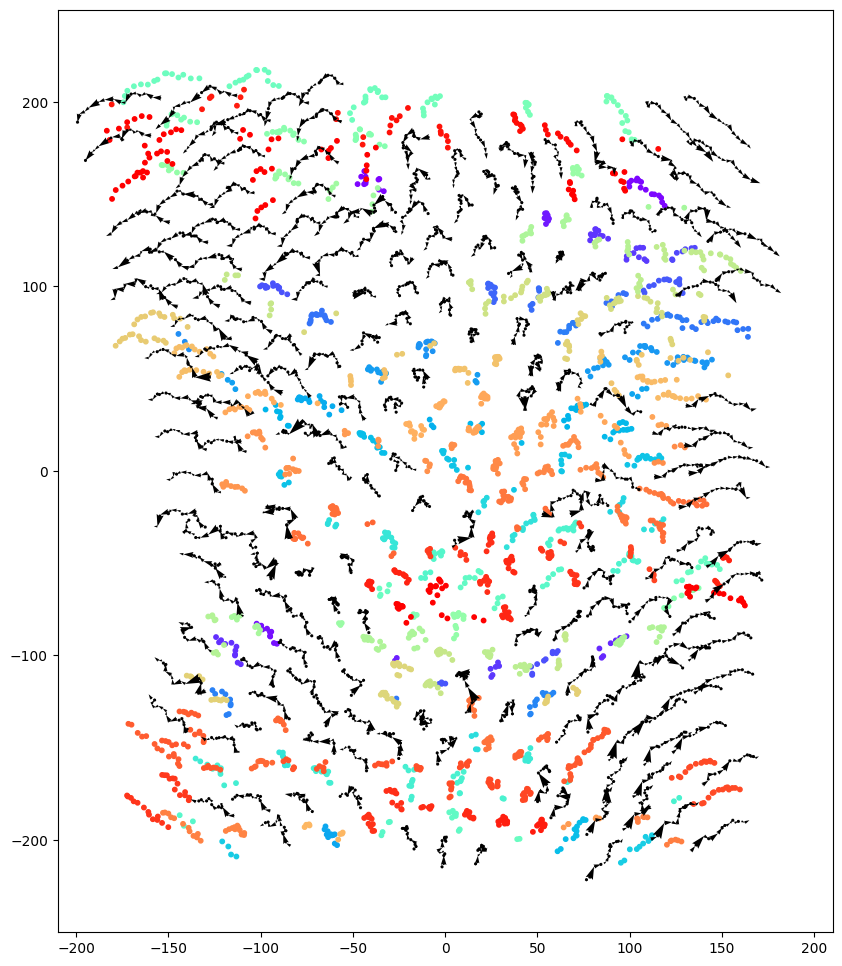

In [17]:
fig, ax = plt.subplots(figsize=(10, 15))

for i in range(16):
    dx= no_div_str.groupby(['cell_id_new']).diff().cc_x[no_div_str.tm_frame==i+1]
    dy=no_div_str.groupby(['cell_id_new']).diff().cc_y[no_div_str.tm_frame==i+1]


    mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

    ax.quiver(no_div_str.cc_x[no_div_str.tm_frame==i],no_div_str.cc_y[no_div_str.tm_frame==i], dx, dy,units='xy', angles='xy', scale=1, zorder=10)
    ax.scatter(div_str.cc_x[div_str.tm_frame==i], div_str.cc_y[div_str.tm_frame==i], c=div_str.cell_id_new[div_str.tm_frame==i], cmap='rainbow', vmin=0, vmax=
    500, s=10)


ax.set_xlim(-210,210)
ax.set_ylim(-250,250)


ax.set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_stretch_traj.png', dpi=300, bbox_inches='tight')

In [18]:
norm = mpl.colors.Normalize(vmin=0, vmax=470)
[cm.jet(norm(x)) for x in np.unique(dat_str.cell_id_new)]

[(0.0, 0.0, 0.5, 1.0),
 (0.0, 0.0, 0.5, 1.0),
 (0.0, 0.0, 0.517825311942959, 1.0),
 (0.0, 0.0, 0.517825311942959, 1.0),
 (0.0, 0.0, 0.535650623885918, 1.0),
 (0.0, 0.0, 0.535650623885918, 1.0),
 (0.0, 0.0, 0.553475935828877, 1.0),
 (0.0, 0.0, 0.553475935828877, 1.0),
 (0.0, 0.0, 0.571301247771836, 1.0),
 (0.0, 0.0, 0.571301247771836, 1.0),
 (0.0, 0.0, 0.589126559714795, 1.0),
 (0.0, 0.0, 0.589126559714795, 1.0),
 (0.0, 0.0, 0.606951871657754, 1.0),
 (0.0, 0.0, 0.624777183600713, 1.0),
 (0.0, 0.0, 0.624777183600713, 1.0),
 (0.0, 0.0, 0.642602495543672, 1.0),
 (0.0, 0.0, 0.642602495543672, 1.0),
 (0.0, 0.0, 0.660427807486631, 1.0),
 (0.0, 0.0, 0.660427807486631, 1.0),
 (0.0, 0.0, 0.67825311942959, 1.0),
 (0.0, 0.0, 0.67825311942959, 1.0),
 (0.0, 0.0, 0.696078431372549, 1.0),
 (0.0, 0.0, 0.696078431372549, 1.0),
 (0.0, 0.0, 0.713903743315508, 1.0),
 (0.0, 0.0, 0.731729055258467, 1.0),
 (0.0, 0.0, 0.731729055258467, 1.0),
 (0.0, 0.0, 0.749554367201426, 1.0),
 (0.0, 0.0, 0.749554367201426, 

In [19]:
dat_rlx.cc_x[dat_rlx.cell_id_new==400]
dat_rlx.groupby('cell_id_new').diff()[dat_rlx.cell_id_new==400].cc_x.iloc[1:]

5790     0.950225
6170     0.702810
6553     0.128314
6934    -0.545937
7317    -0.581025
7704    -1.245316
8095    -0.477133
8488     0.394016
8885     0.647727
9282     0.562939
9682    -0.447825
10083   -0.684563
10483    0.300124
10886    0.523688
Name: cc_x, dtype: float64

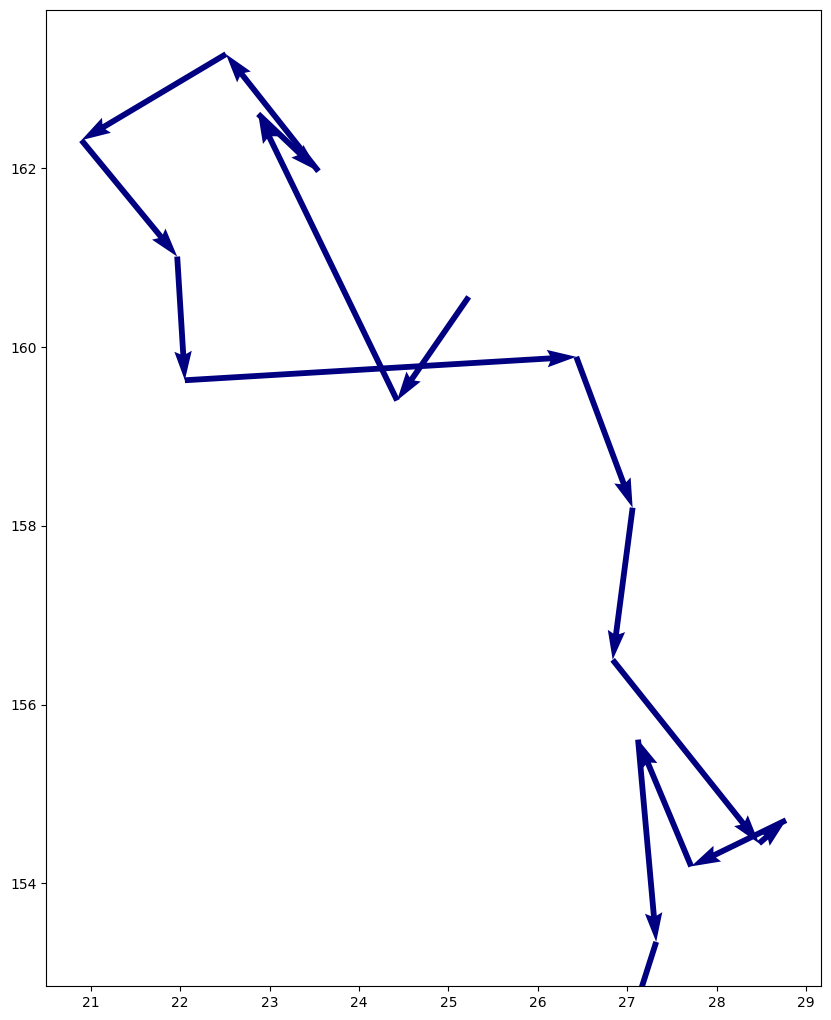

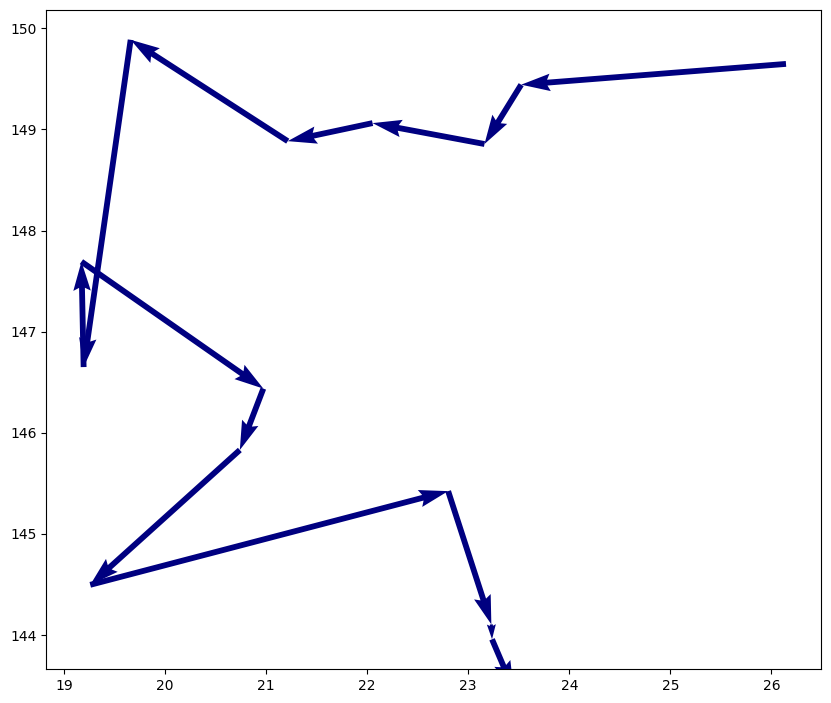

In [20]:
fig, ax = plt.subplots(figsize=(10, 15))

norm = mpl.colors.Normalize(vmin=0, vmax=np.max(np.unique(dat_str.cell_id_new)))
colours=[cm.jet(norm(x)) for x in range(np.max(np.unique(dat_str.cell_id_new))+1)]

for i in np.unique(dat_str.cell_id_new)[:1]:
    dx= dat_str.groupby('cell_id_new').diff()[dat_str.cell_id_new==i].cc_x.iloc[1:]
    dy=dat_str.groupby('cell_id_new').diff()[dat_str.cell_id_new==i].cc_y.iloc[1:]
    X=dat_str.cc_x[dat_str.cell_id_new==i].iloc[:-1]
    Y=dat_str.cc_y[dat_str.cell_id_new==i].iloc[:-1]
    if len(dx)==len(X):

        mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

        ax.quiver(X,Y, dx, dy,units='xy', angles='xy', scale=1, zorder=10, color=colours[i])


# ax.set_xlim(-400,400)
# ax.set_ylim(-450,450)


ax.set_aspect('equal')
#plt.savefig(plot_dir+'/cell_centre_stretch_traj.png', dpi=300, bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(10, 15))

norm = mpl.colors.Normalize(vmin=0, vmax=np.max(np.unique(dat_rlx.cell_id_new)))
colours=[cm.jet(norm(x)) for x in range(np.max(np.unique(dat_rlx.cell_id_new))+1)]

for i in np.unique(dat_rlx.cell_id_new)[:1]:
    dx= dat_rlx.groupby('cell_id_new').diff()[dat_rlx.cell_id_new==i].cc_x.iloc[1:]
    dy=dat_rlx.groupby('cell_id_new').diff()[dat_rlx.cell_id_new==i].cc_y.iloc[1:]
    X=dat_rlx.cc_x[dat_rlx.cell_id_new==i].iloc[:-1]
    Y=dat_rlx.cc_y[dat_rlx.cell_id_new==i].iloc[:-1]
    if len(dx)==len(X):

        mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

        ax.quiver(X,Y, dx, dy,units='xy', angles='xy', scale=1, zorder=10, color=colours[i])


# ax.set_xlim(-400,400)
# ax.set_ylim(-450,450)


ax.set_aspect('equal')
#plt.savefig(plot_dir+'/cell_centre_relax_traj.png', dpi=300, bbox_inches='tight')


In [437]:
dat_str.groupby('cell_id_new').diff().cc_x

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5512   -3.681759
5513    6.618241
5514   -3.253187
5515   -5.281759
5516   -2.681759
Name: cc_x, Length: 5517, dtype: float64

In [22]:
orig_cells.groupby(['cell_id_new']).diff().cc_x

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
10761    0.124677
10762    0.755372
10763    0.106657
10764    0.034577
10765   -0.433939
Name: cc_x, Length: 6265, dtype: float64

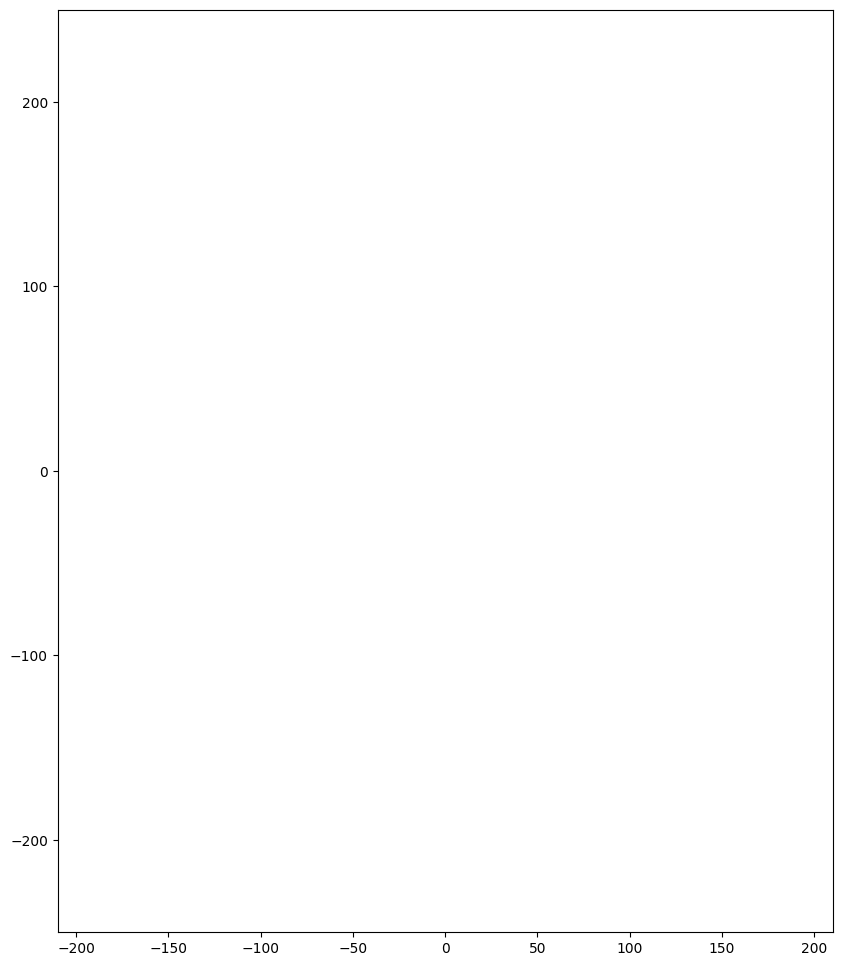

In [21]:
fig, ax = plt.subplots(figsize=(10, 15))

for i in range(16):
    dx= orig_cells.groupby(['cell_id_new']).diff().cc_x[orig_cells.tm_frame==i+1]
    dy=orig_cells.groupby(['cell_id_new']).diff().cc_y[orig_cells.tm_frame==i+1]
    X=orig_cells.cc_x[orig_cells.tm_frame==i]
    Y=orig_cells.cc_y[orig_cells.tm_frame==i]

    if len(dx)==len(X):

        mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

        ax.quiver(X,Y, dx, dy,units='xy', angles='xy', scale=1, zorder=10)
        #ax.scatter(div_rlx.cc_x[div_rlx.tm_frame==i], div_rlx.cc_y[div_rlx.tm_frame==i], c=div_rlx.cell_id_new[div_rlx.tm_frame==i], cmap='rainbow', vmin=0, vmax=550)


ax.set_xlim(-210,210)
ax.set_ylim(-250,250)


ax.set_aspect('equal')
#plt.savefig(plot_dir+'/cell_centre_stretch_traj.png', dpi=300, bbox_inches='tight')
plt.show()

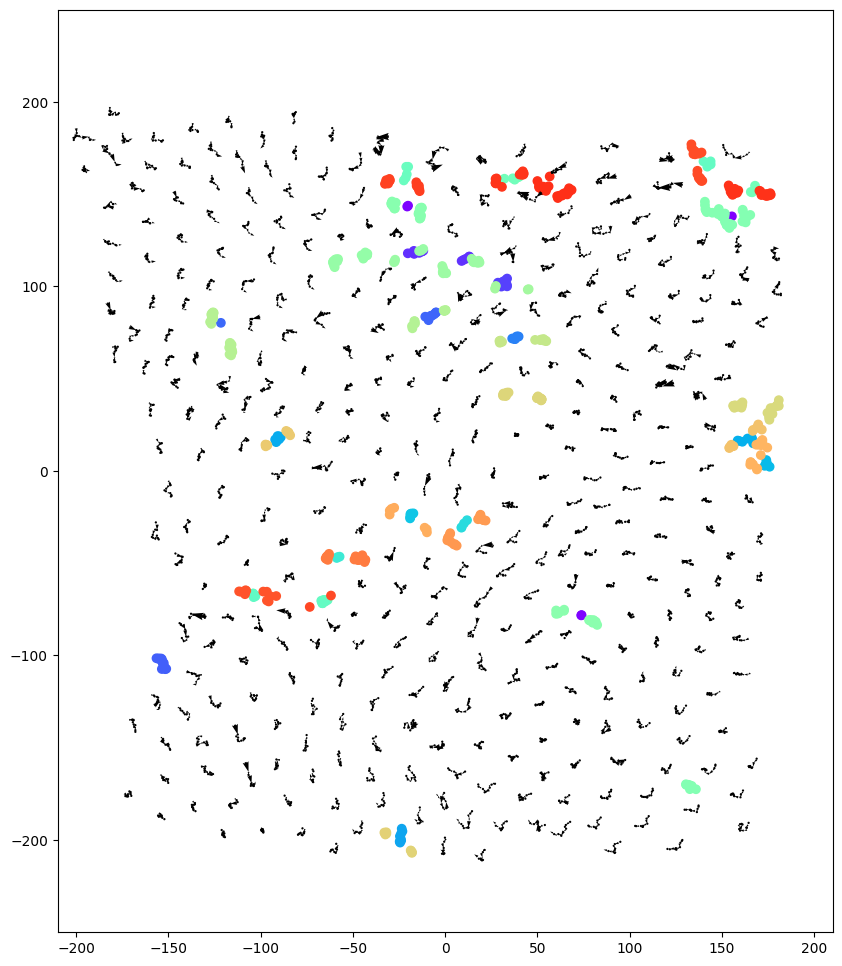

In [23]:
fig, ax = plt.subplots(figsize=(10, 15))

for i in range(17, 30):
    dx= no_div_rlx.groupby(['cell_id_new']).diff().cc_x[no_div_rlx.tm_frame==i+1]
    dy=no_div_rlx.groupby(['cell_id_new']).diff().cc_y[no_div_rlx.tm_frame==i+1]


    mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

    ax.quiver(no_div_rlx.cc_x[no_div_rlx.tm_frame==i],no_div_rlx.cc_y[no_div_rlx.tm_frame==i], dx, dy,units='xy', angles='xy', scale=1, zorder=10)
    ax.scatter(div_rlx.cc_x[div_rlx.tm_frame==i], div_rlx.cc_y[div_rlx.tm_frame==i], c=div_rlx.cell_id_new[div_rlx.tm_frame==i], cmap='rainbow', vmin=0, vmax=550)


ax.set_xlim(-210,210)
ax.set_ylim(-250,250)


ax.set_aspect('equal')
#plt.savefig(plot_dir+'/cell_centre_relax_traj.png', dpi=300, bbox_inches='tight')

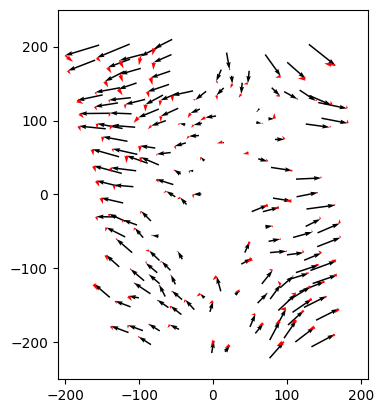

In [24]:
dx= cc_us.cc_dx
dy=cc_us.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_us.cc_x_u,cc_us.cc_y_u, dx, dy,units='xy', angles='xy', scale=1, zorder=10)

dx= cc_sr.cc_dx
dy=cc_sr.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10, color='red')
plt.xlim(-210,210)
plt.ylim(-250,250)


plt.gca().set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_displacement_total_no_div.png', dpi=300, bbox_inches='tight')

In [25]:
nds_t0=no_div_str[no_div_str.tm_frame==0][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
nds_t80=no_div_str[no_div_str.tm_frame==16][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]

ndr_t80=no_div_rlx[no_div_rlx.tm_frame==16][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
ndr_t150=no_div_rlx[no_div_rlx.tm_frame==np.max(dat_df.tm_frame)][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]

cc_us=pd.merge(nds_t0, nds_t80, on='cell_id_new', suffixes=("_u", "_s"))
cc_us['cc_dx']=cc_us.cc_x_s-cc_us.cc_x_u
cc_us['cc_dy']=cc_us.cc_y_s-cc_us.cc_y_u

cc_sr=pd.merge(ndr_t80, ndr_t150, on='cell_id_new', suffixes=("_s", "_r"))
cc_sr['cc_dx']=cc_sr.cc_x_r-cc_sr.cc_x_s
cc_sr['cc_dy']=cc_sr.cc_y_r-cc_sr.cc_y_s

cc_s_0=np.transpose(np.vstack((cc_us.cc_x_u, cc_us.cc_y_u)))
cc_s_80=np.transpose(np.vstack((cc_us.cc_x_s, cc_us.cc_y_s)))
aft=np.array(cv2.estimateAffine2D(cc_s_0, cc_s_80, method=cv2.RANSAC)[0][:,:2])
print(aft)
print(polar(aft))

cc_r_80=np.transpose(np.vstack((cc_sr.cc_x_s, cc_sr.cc_y_s)))
cc_r_150=np.transpose(np.vstack((cc_sr.cc_x_r, cc_sr.cc_y_r)))
aft=np.array(cv2.estimateAffine2D(cc_r_80, cc_r_150, method=cv2.RANSAC)[0][:,:2])
print(aft)
print(polar(aft))

[[ 1.17609315 -0.05328657]
 [-0.0188081   0.92206421]]
(array([[ 0.99986501, -0.01643052],
       [ 0.01643052,  0.99986501]]), array([[ 1.17562536, -0.03812938],
       [-0.03812938,  0.92281527]]))
[[0.9677776  0.00739453]
 [0.02089507 0.98959779]]
(array([[ 0.99997621, -0.0068971 ],
       [ 0.0068971 ,  0.99997621]]), array([[0.96789869, 0.01421971],
       [0.01421971, 0.98952325]]))


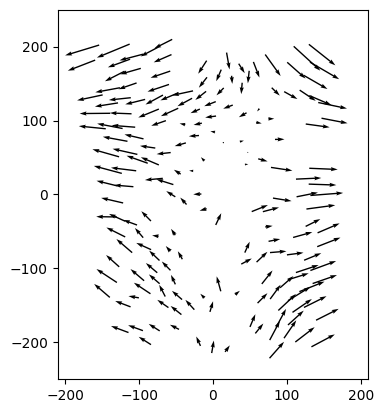

In [26]:
dx= cc_us.cc_dx
dy=cc_us.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_us.cc_x_u,cc_us.cc_y_u, dx, dy,units='xy', angles='xy', scale=1, zorder=10)

dx= cc_sr.cc_dx
dy=cc_sr.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

#plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10, color='red')
plt.xlim(-210,210)
plt.ylim(-250,250)


plt.gca().set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_stretch.png', dpi=300, bbox_inches='tight')

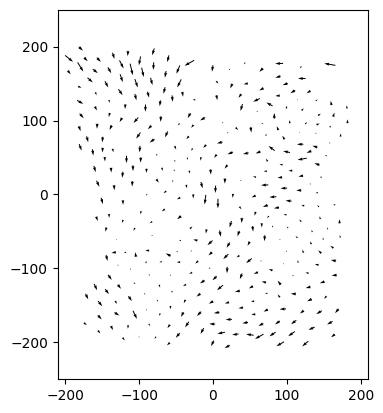

In [27]:
dx= cc_sr.cc_dx
dy=cc_sr.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10)
plt.xlim(-210,210)
plt.ylim(-250,250)


plt.gca().set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_relaxation.png', dpi=300, bbox_inches='tight')

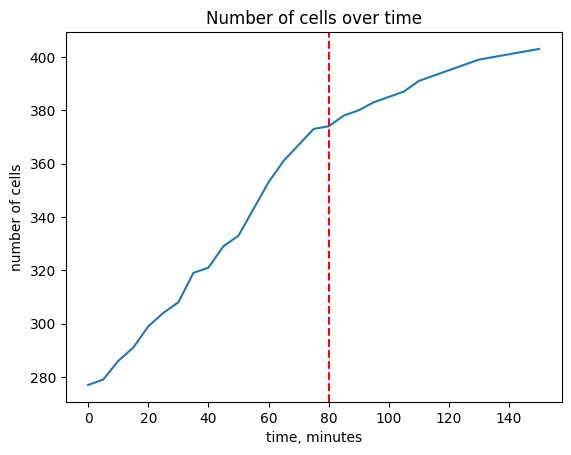

In [28]:
plt.plot(dat_df.groupby('time').count().cell_id_new)
plt.axvline(80, c='r', linestyle='--')
plt.xlabel('time, minutes')
plt.ylabel('number of cells')
plt.title("Number of cells over time")

plt.savefig(plot_dir+'/Number_cells_time.png', dpi=300, bbox_inches='tight')

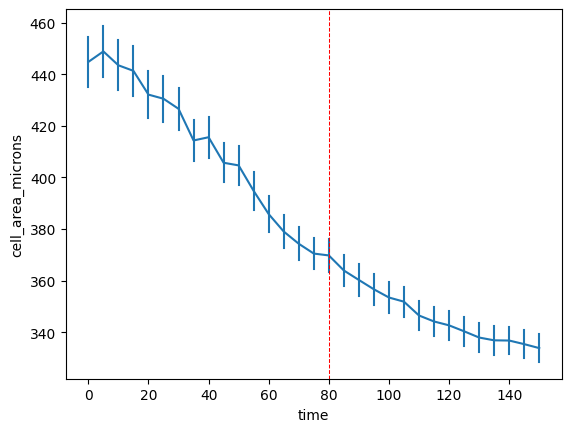

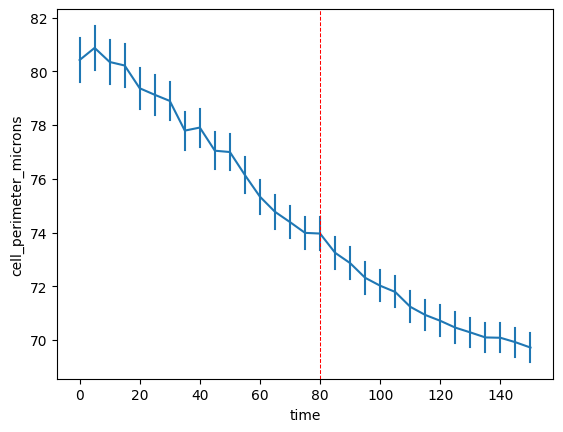

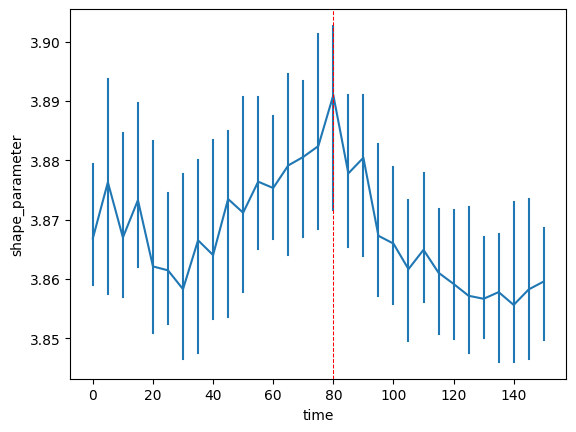

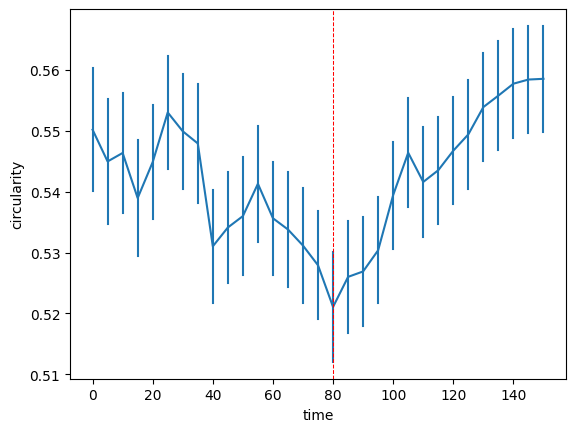

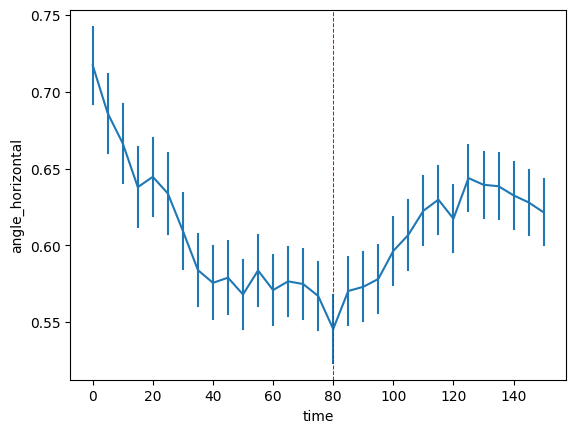

In [29]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

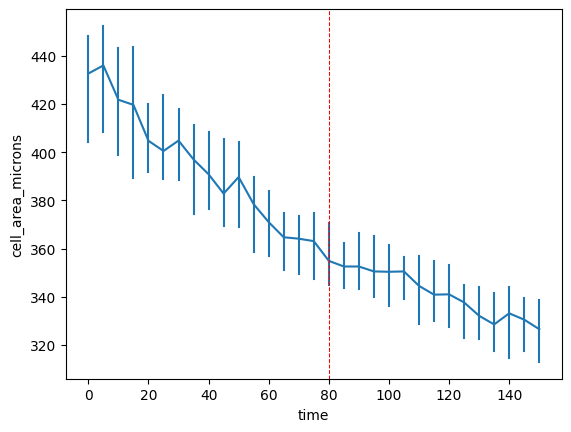

In [30]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', estimator='median')
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()

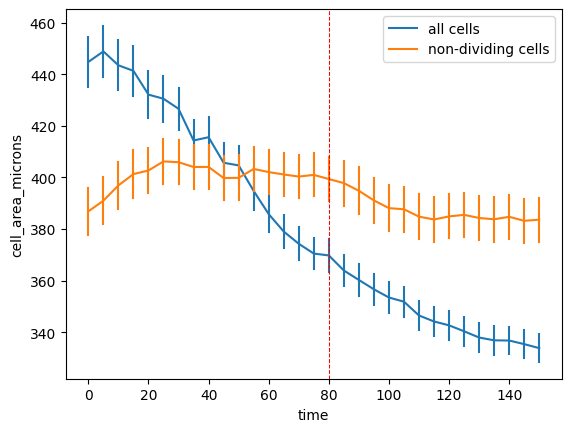

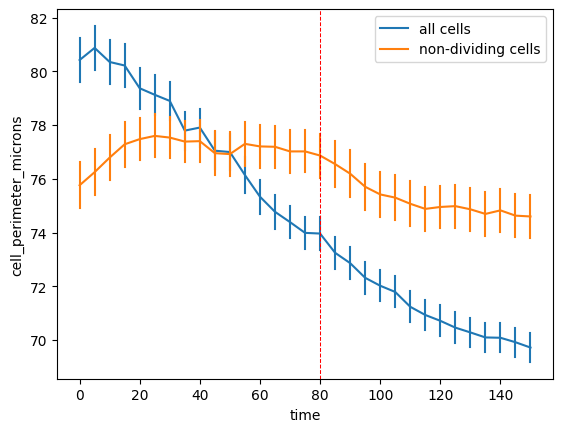

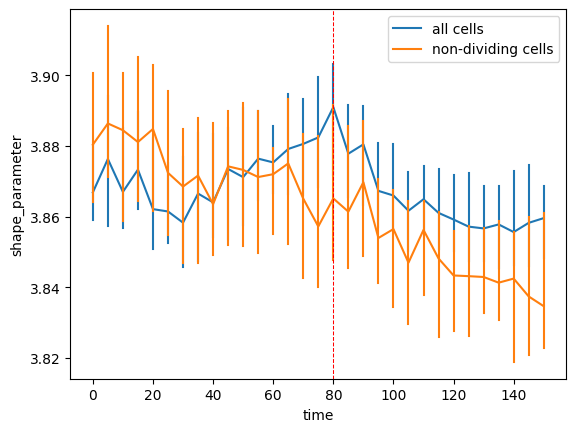

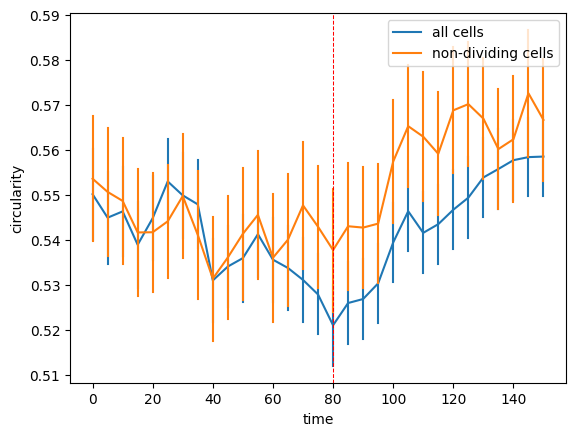

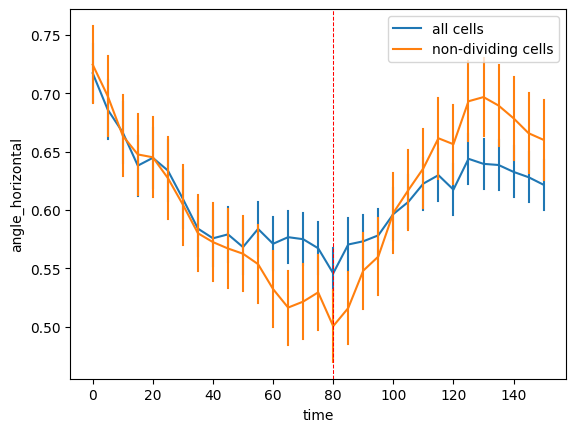

In [31]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median', label='all cells')
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

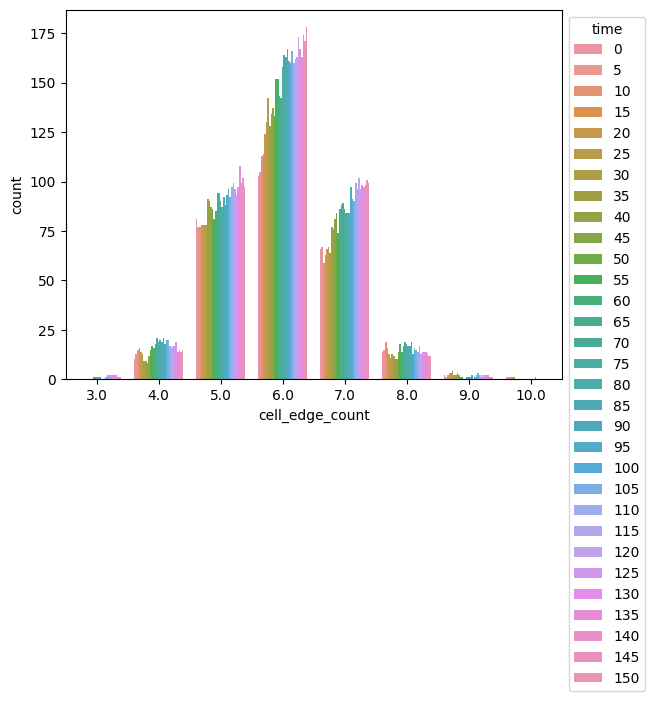

In [32]:
sns.countplot(data=dat_df,x='cell_edge_count', hue='time')
plt.legend( loc="upper left", bbox_to_anchor=(1, 1), title='time')
plt.savefig(plot_dir+'/cell_edges_hist.png', dpi=300, bbox_inches='tight')

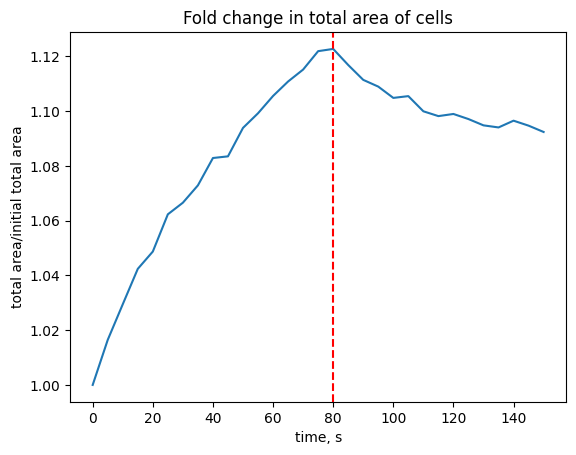

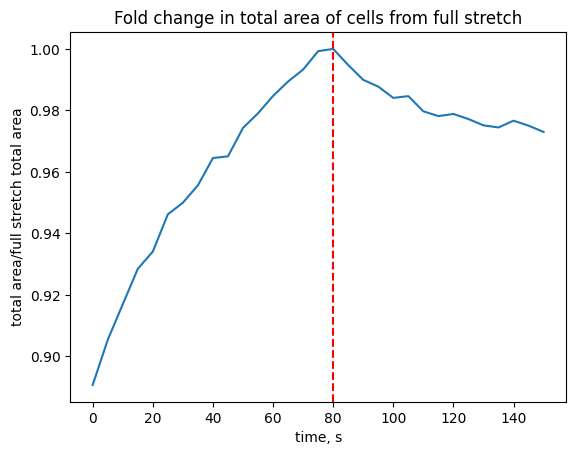

In [33]:
t=np.linspace(0, 150, 31)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==0].sum().cell_area_microns))
plt.axvline(80, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/initial total area")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area.png', dpi=300, bbox_inches='tight')

plt.show()

t=np.linspace(0, 150, 31)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==80].sum().cell_area_microns))
plt.axvline(80, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/full stretch total area")
plt.title("Fold change in total area of cells from full stretch")
plt.savefig(plot_dir+'/total_area_full_stretch.png', dpi=300, bbox_inches='tight')

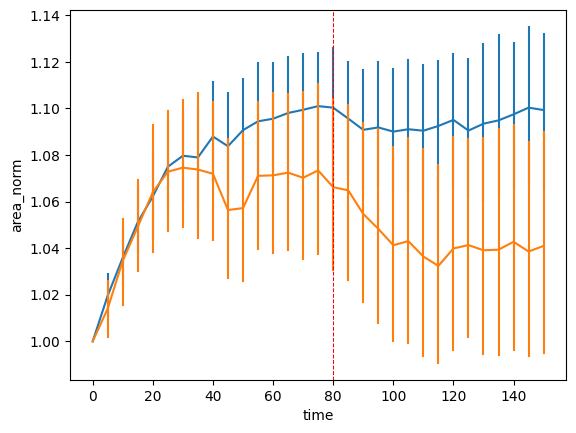

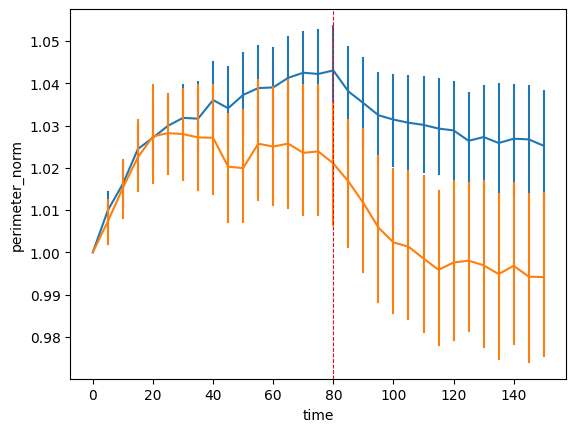

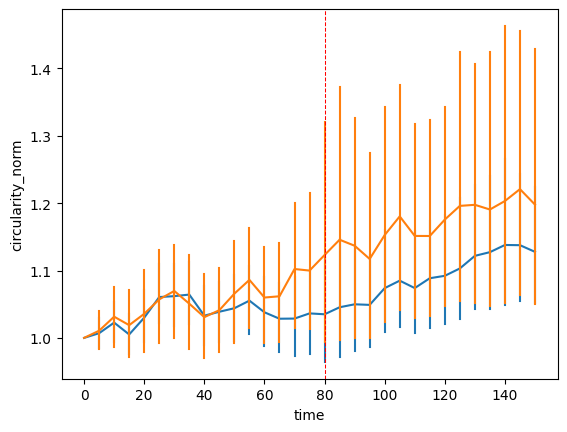

In [34]:
sns.lineplot(data=dat_df, y='area_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='area_norm', x='time',err_style='bars')

plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_area_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=dat_df, y='perimeter_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='perimeter_norm', x='time',err_style='bars')

plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_perimeter_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()


sns.lineplot(data=dat_df, y='circularity_norm', x='time',err_style='bars')
sns.lineplot(data=no_div, y='circularity_norm', x='time',err_style='bars')

plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circ_norm_time.png', dpi=300, bbox_inches='tight')
plt.show()

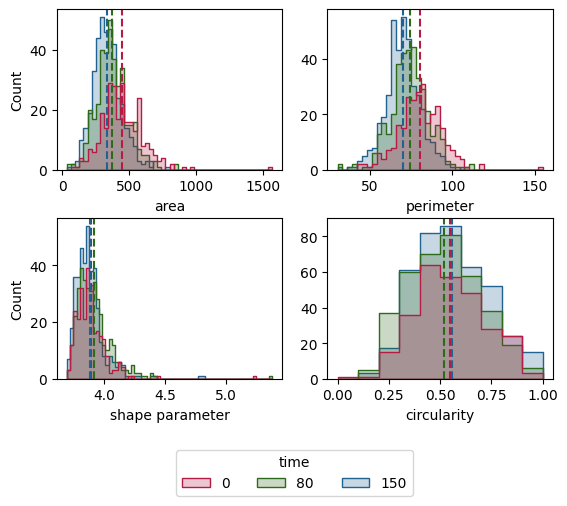

In [35]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==150)], hue='time',x='cell_area_microns', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,0], legend=False)
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==0].cell_area_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==80].cell_area_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==150].cell_area_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==150)], hue='time',x='cell_perimeter_microns', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,1], legend=False)
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==0].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==80].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==150].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==150)], hue='time',x='circularity', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[1,1], legend=False , binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==0].circularity), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==80].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==150].circularity), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==80)| (dat_df.time==150)], hue='time',x='shape_parameter', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[1,0], legend=True)
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==0].shape_parameter), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==80].shape_parameter), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==150].shape_parameter), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -0.4), frameon=True, ncol=3)
plt.savefig(plot_dir+'/cell_quantities_hists.png', dpi=300, bbox_inches='tight')

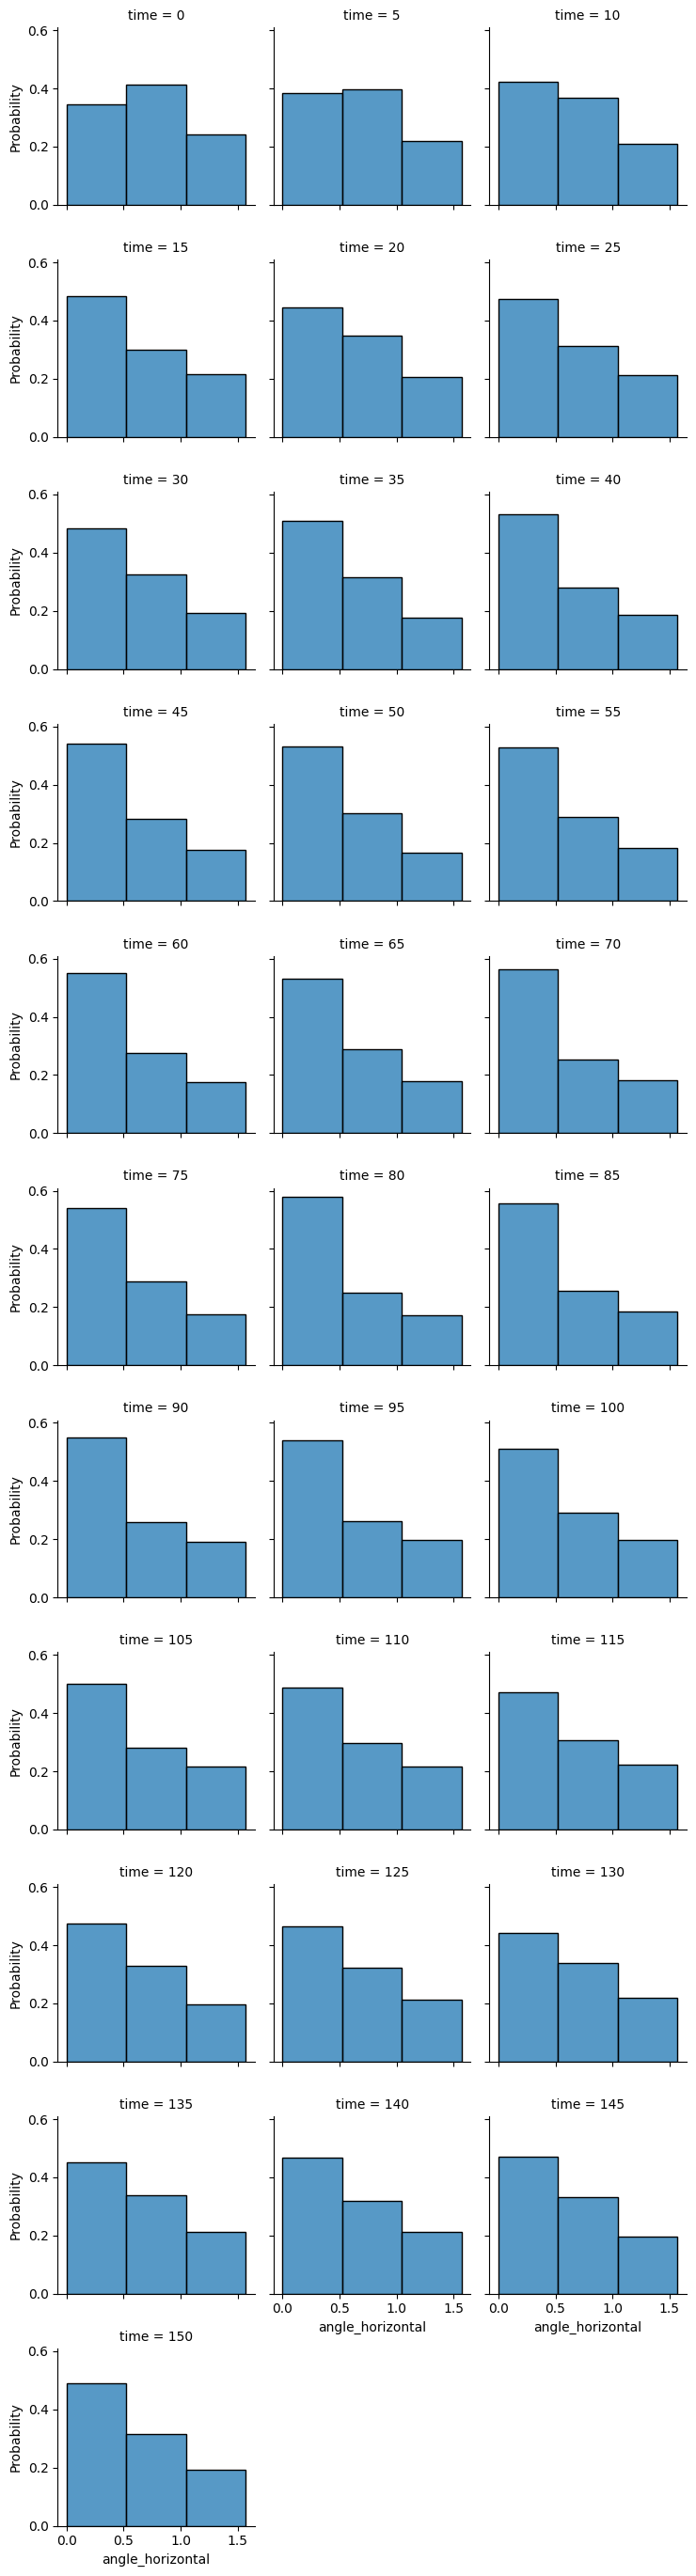

In [36]:
g = sns.FacetGrid(dat_df, col="time", height=2.5, col_wrap=3)
g.map(sns.histplot, "angle_horizontal", stat='probability', binrange=[0, np.pi/2],bins=3)

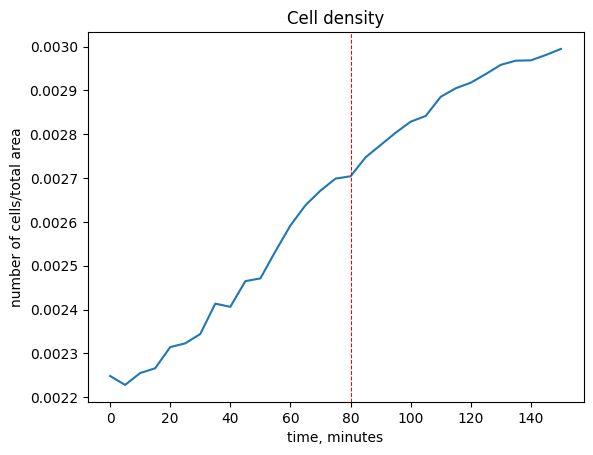

In [37]:
#cell density
plt.plot(dat_df.groupby('time').count().cell_id_new/(dat_df.groupby('time').cell_area_microns.sum()))
plt.axvline(80, c='r', linestyle='--', linewidth=0.75)

plt.xlabel('time, minutes')
plt.ylabel('number of cells/total area')
plt.title("Cell density")

plt.savefig(plot_dir+'/cell_density_time.png', dpi=300, bbox_inches='tight')

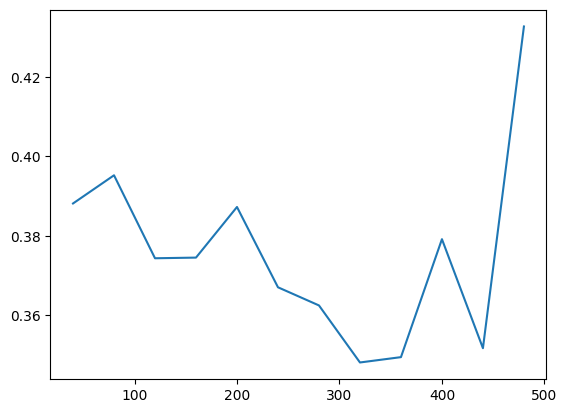

In [38]:
shape_cos=np.cos(np.subtract.outer(dat_df[dat_df.time==0].major_shape_axis_alignment_rads.values,dat_df[dat_df.time==0].major_shape_axis_alignment_rads.values))
r = np.sqrt(np.subtract.outer(dat_df[dat_df.time==0].cc_x.values, dat_df[dat_df.time==0].cc_x.values)**2 +
                np.subtract.outer(dat_df[dat_df.time==0].cc_y.values, dat_df[dat_df.time==0].cc_y.values)**2)
upper_triangle = np.triu_indices_from(r, 1)
c_func_shape=pd.DataFrame({'r': r[upper_triangle],
                        'dot_product': shape_cos[upper_triangle]})
n=101
#bins=np.linspace(c_func.r.min(),c_func.r.max(), n)
bins=np.arange(0, c_func_shape.r.max(), 40)
shape_corr=[]
for i in range(1,len(bins)):
    c_bin=c_func_shape[(c_func_shape.r>bins[i-1])&(c_func_shape.r<=bins[i])]
    mean_corr=c_bin.dot_product.mean()
    shape_corr.append(mean_corr)

plt.plot(bins[:-1]+np.diff(bins), shape_corr)

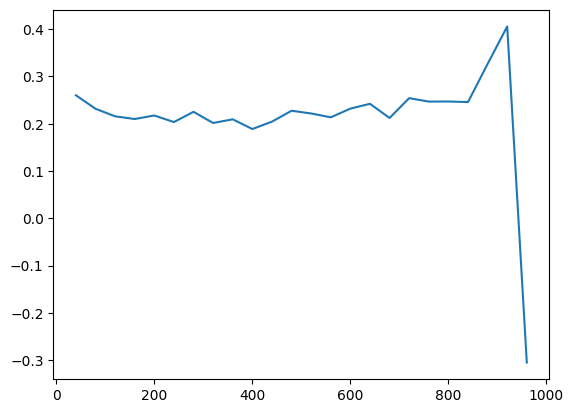

In [10]:
shape_cos=np.cos(np.subtract.outer(dat_df[dat_df.time==80].major_shape_axis_alignment_rads.values,dat_df[dat_df.time==80].major_shape_axis_alignment_rads.values))
r = np.sqrt(np.subtract.outer(dat_df[dat_df.time==80].cc_x.values, dat_df[dat_df.time==80].cc_x.values)**2 +
                np.subtract.outer(dat_df[dat_df.time==80].cc_y.values, dat_df[dat_df.time==80].cc_y.values)**2)
upper_triangle = np.triu_indices_from(r, 1)
c_func_shape=pd.DataFrame({'r': r[upper_triangle],
                        'dot_product': shape_cos[upper_triangle]})
n=101
#bins=np.linspace(c_func.r.min(),c_func.r.max(), n)
bins=np.arange(0, c_func_shape.r.max(), 40)
shape_corr=[]
for i in range(1,len(bins)):
    c_bin=c_func_shape[(c_func_shape.r>bins[i-1])&(c_func_shape.r<=bins[i])]
    mean_corr=c_bin.dot_product.mean()
    shape_corr.append(mean_corr)

plt.plot(bins[:-1]+np.diff(bins), shape_corr)

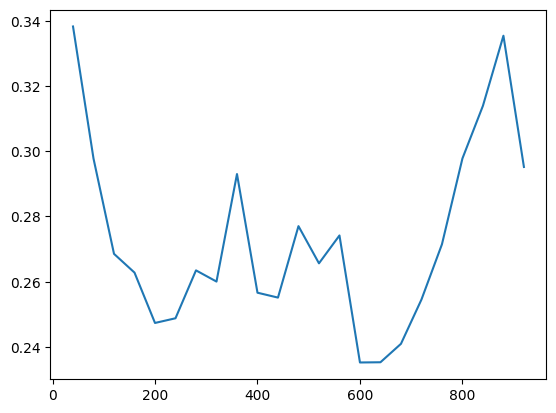

In [12]:
shape_cos=np.cos(np.subtract.outer(dat_df[dat_df.time==30].major_shape_axis_alignment_rads.values,dat_df[dat_df.time==30].major_shape_axis_alignment_rads.values))
r = np.sqrt(np.subtract.outer(dat_df[dat_df.time==30].cc_x.values, dat_df[dat_df.time==30].cc_x.values)**2 +
                np.subtract.outer(dat_df[dat_df.time==30].cc_y.values, dat_df[dat_df.time==30].cc_y.values)**2)
upper_triangle = np.triu_indices_from(r, 1)
c_func_shape=pd.DataFrame({'r': r[upper_triangle],
                        'dot_product': shape_cos[upper_triangle]})
n=101
#bins=np.linspace(c_func.r.min(),c_func.r.max(), n)
bins=np.arange(0, c_func_shape.r.max(), 40)
shape_corr=[]
for i in range(1,len(bins)):
    c_bin=c_func_shape[(c_func_shape.r>bins[i-1])&(c_func_shape.r<=bins[i])]
    mean_corr=c_bin.dot_product.mean()
    shape_corr.append(mean_corr)

plt.plot(bins[:-1]+np.diff(bins), shape_corr)

In [12]:
daughter_cells['aligned_time']=daughter_cells['time']-daughter_cells.groupby('cell_id_new')['time'].transform('first')

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_36312\2948227597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daughter_cells['aligned_time']=daughter_cells['time']-daughter_cells.groupby('cell_id_new')['time'].transform('first')


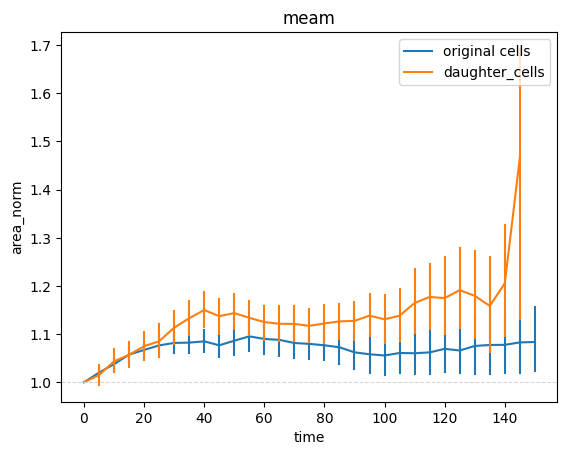

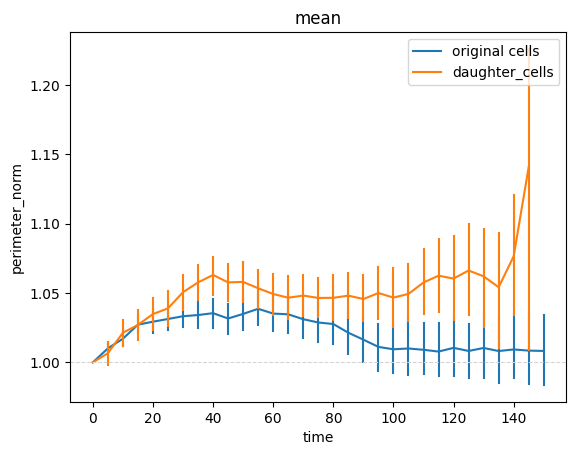

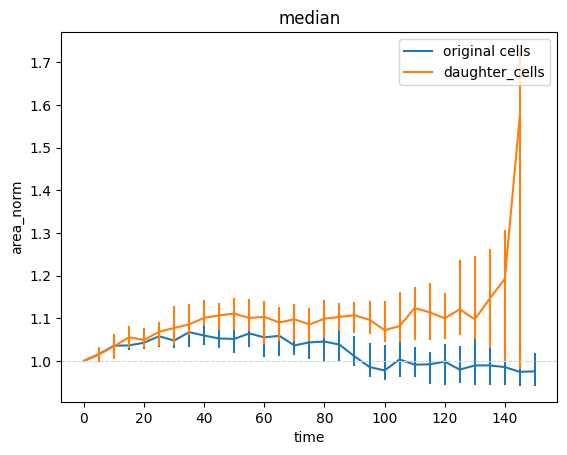

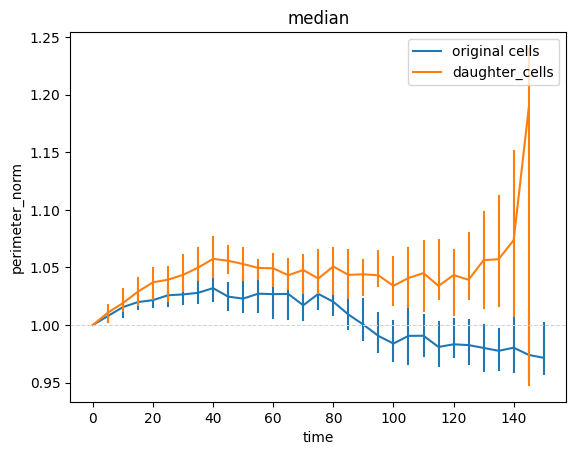

In [46]:

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='area_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('meam')
plt.legend()
plt.savefig(plot_dir+'/mean_area_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='aligned_time',err_style='bars', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('mean')
plt.legend()
plt.savefig(plot_dir+'/mean_perimeter_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells', estimator='median')
sns.lineplot(data=daughter_cells, y='area_norm', x='aligned_time',err_style='bars', estimator='median',label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('median')
plt.legend()
plt.savefig(plot_dir+'/median_area_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars', estimator='median', label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='aligned_time',err_style='bars',estimator='median', label='daughter_cells')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('median')
plt.legend()
plt.savefig(plot_dir+'/median_perimeter_norm_time_o_d_time_aligned.png', dpi=300, bbox_inches='tight')
plt.show()


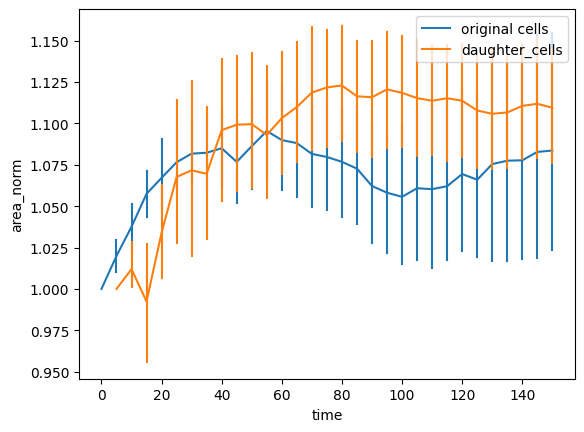

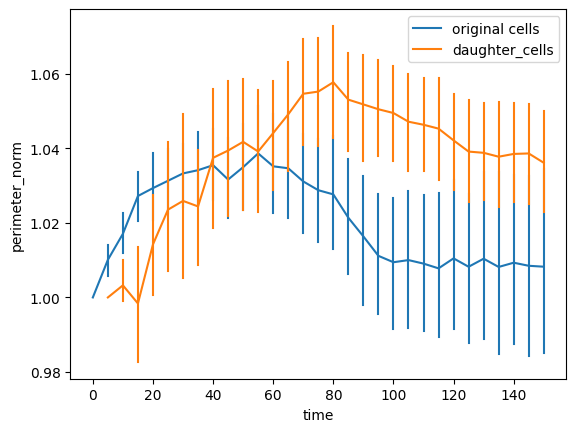

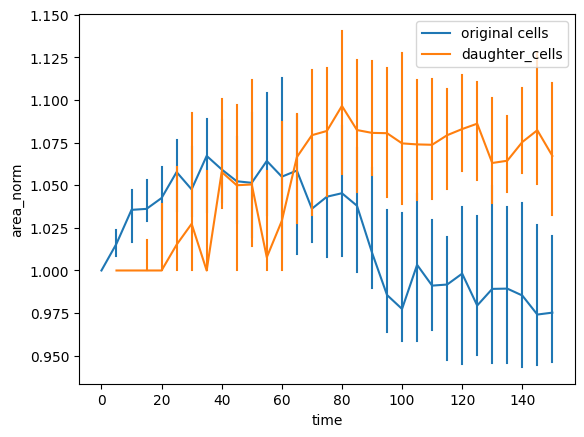

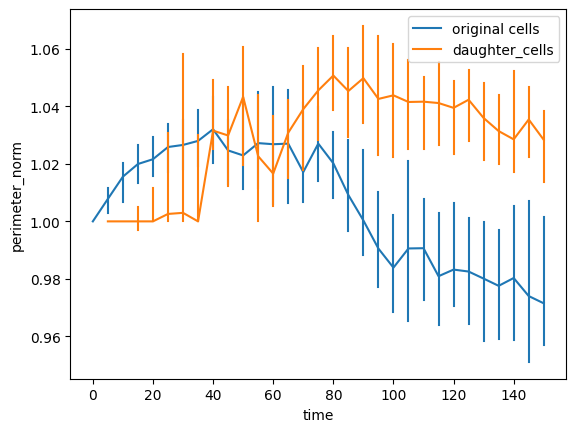

In [42]:

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='area_norm', x='time',err_style='bars', label='daughter_cells')
plt.legend()
plt.savefig(plot_dir+'/mean_area_norm_time_o_d_time.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars',label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='time',err_style='bars', label='daughter_cells')
plt.legend()
plt.savefig(plot_dir+'/mean_perimeter_norm_time_o_d_time.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='area_norm', x='time',err_style='bars',label='original cells', estimator='median')
sns.lineplot(data=daughter_cells, y='area_norm', x='time',err_style='bars', estimator='median',label='daughter_cells')
plt.legend()
plt.savefig(plot_dir+'/median_area_norm_time_o_d_time.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=orig_cells, y='perimeter_norm', x='time',err_style='bars', estimator='median', label='original cells')
sns.lineplot(data=daughter_cells, y='perimeter_norm', x='time',err_style='bars',estimator='median', label='daughter_cells')
plt.legend()
plt.savefig(plot_dir+'/median_perimeter_norm_time_o_d_time.png', dpi=300, bbox_inches='tight')
plt.show()

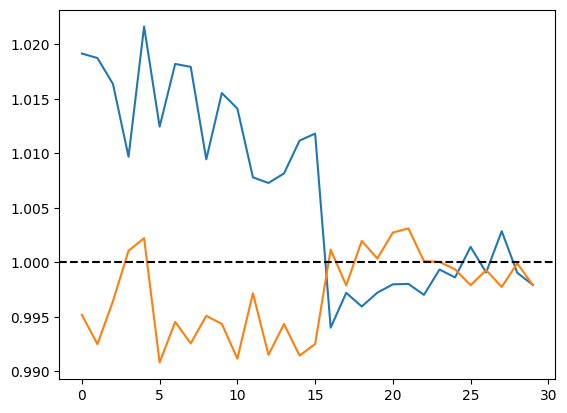

In [8]:
trans=[]
for i in np.unique(dat_df.tm_frame)[:-1]:
    cells=list(set(dat_df[dat_df.tm_frame==i+1].cell_id_new).intersection(set(dat_df[dat_df.tm_frame==i].cell_id_new)))
    cell_fr=dat_df[(dat_df.cell_id_new.isin(cells))]
    cc_i=np.transpose(np.vstack((cell_fr[cell_fr.tm_frame==i].cc_x, cell_fr[cell_fr.tm_frame==i].cc_y)))
    cc_f=np.transpose(np.vstack((cell_fr[cell_fr.tm_frame==i+1].cc_x, cell_fr[cell_fr.tm_frame==i+1].cc_y)))
    aft=np.array(cv2.estimateAffine2D(cc_i, cc_f, method=cv2.RANSAC)[0][:,:2])
    trans.append(polar(aft)[1].diagonal())
trans=np.array(trans)

plt.plot(trans[:,0])
plt.plot(trans[:,1])
plt.axhline(1,c='k', linestyle='--')

In [25]:
div_stretch=np.array(daughter_cells.groupby('cell_id_new').first().time[daughter_cells.groupby('cell_id_new').first().time>=80].index)

In [28]:
d_c_stretch=daughter_cells[daughter_cells.cell_id_new.isin(div_stretch)]
d_c_post=daughter_cells[~daughter_cells.cell_id_new.isin(div_stretch)]

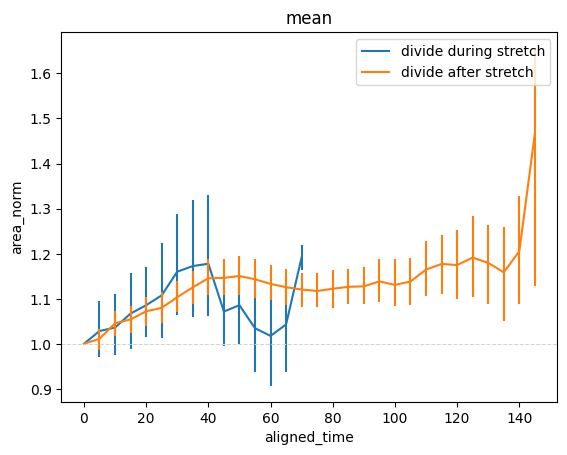

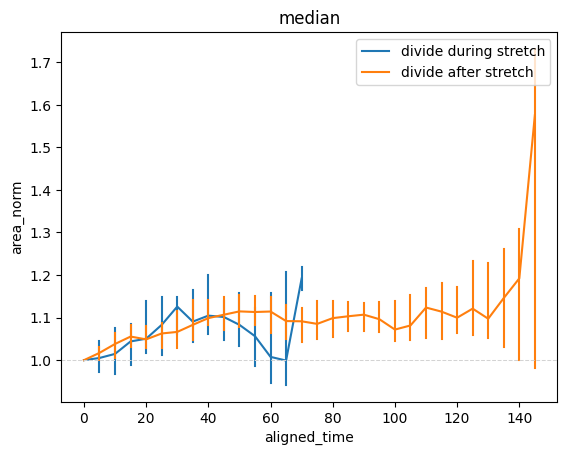

In [32]:

sns.lineplot(data=d_c_stretch, y='area_norm', x='aligned_time',err_style='bars',label='divide during stretch')
sns.lineplot(data=d_c_post, y='area_norm', x='aligned_time',err_style='bars', label='divide after stretch')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('mean')
plt.legend()
plt.savefig(plot_dir+'/mean_area_norm_time_o_d_time_aligned__split_stretch.png', dpi=300, bbox_inches='tight')
plt.show()

sns.lineplot(data=d_c_stretch, y='area_norm', x='aligned_time',err_style='bars',label='divide during stretch', estimator='median')
sns.lineplot(data=d_c_post, y='area_norm', x='aligned_time',err_style='bars', label='divide after stretch', estimator='median')
plt.axhline(1, linestyle='--', color='lightgrey', linewidth=0.75)
plt.title('median')
plt.legend()
plt.savefig(plot_dir+'/median_area_norm_time_o_d_time_aligned_split_stretch.png', dpi=300, bbox_inches='tight')
plt.show()


In [1]:
shape_cos_sq=np.cos(np.subtract.outer(dat_df[dat_df.tm_frame==0].major_shape_axis_alignment_rads.values,dat_df[dat_df.tm_frame==0].major_shape_axis_alignment_rads.values))**2


NameError: name 'np' is not defined